In [12]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import clean as clean
from sklearn.impute import SimpleImputer

In [14]:
# Load the raw data
dt_raw = pd.read_csv('../data/TBI PUD 10-08-2013.csv')
dt_clean = clean.clean_data('../data/TBI PUD 10-08-2013.csv', remove_feats_after_ct=True, remove_TBI_rows_with_nan=True,threshold=0.5,rm_feats=True,remove_GCS_total_mismatch=True)

False Negative Rates for each method:
Baseline: 0.5390
SMOTE: 0.1688
Undersampling: 0.1753
Class Weighting: 0.1623


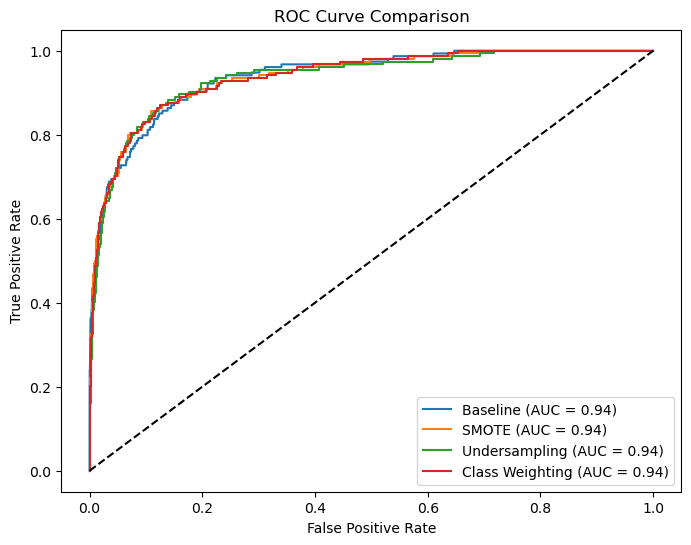

Classification Report for SMOTE:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      8254
         1.0       0.13      0.83      0.23       154

    accuracy                           0.90      8408
   macro avg       0.57      0.87      0.59      8408
weighted avg       0.98      0.90      0.93      8408



In [15]:
# Sample dataset (replace this with your actual data)
X = dt_clean.drop(columns=["PosIntFinal"])  # Features
y = dt_clean["PosIntFinal"]  # Target

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values
imputer = SimpleImputer(strategy='mean')  # Replace NaN with mean
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Helper function to calculate False Negative Rate
def evaluate_fnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]
    tp = cm[1, 1]
    return fn / (fn + tp)

# Helper function to plot ROC curve
def plot_roc(y_true, y_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

# Store results
results = {}

### 1. Baseline Model (Without Class Imbalance Handling)
lda_baseline = LinearDiscriminantAnalysis()
lda_baseline.fit(X_train, y_train)
y_pred_baseline = lda_baseline.predict(X_test)
y_proba_baseline = lda_baseline.predict_proba(X_test)[:, 1]
results['Baseline'] = evaluate_fnr(y_test, y_pred_baseline)

### 2. SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

lda_smote = LinearDiscriminantAnalysis()
lda_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lda_smote.predict(X_test)
y_proba_smote = lda_smote.predict_proba(X_test)[:, 1]
results['SMOTE'] = evaluate_fnr(y_test, y_pred_smote)

### 3. Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

lda_under = LinearDiscriminantAnalysis()
lda_under.fit(X_train_under, y_train_under)
y_pred_under = lda_under.predict(X_test)
y_proba_under = lda_under.predict_proba(X_test)[:, 1]
results['Undersampling'] = evaluate_fnr(y_test, y_pred_under)

### 4. Class Weighting (Simulated by Resampling)
# Oversample the minority class to simulate class weighting
from sklearn.utils import resample

# Combine X_train and y_train into one dataset
train_data = np.hstack((X_train, y_train.values.reshape(-1, 1)))

# Separate majority and minority classes
majority = train_data[y_train == 0]
minority = train_data[y_train == 1]

# Oversample the minority class
minority_oversampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)

# Combine back into a balanced dataset
train_balanced = np.vstack((majority, minority_oversampled))
np.random.shuffle(train_balanced)  # Shuffle the dataset

# Split features and target
X_train_balanced = train_balanced[:, :-1]
y_train_balanced = train_balanced[:, -1]

lda_weighted = LinearDiscriminantAnalysis()
lda_weighted.fit(X_train_balanced, y_train_balanced)
y_pred_weighted = lda_weighted.predict(X_test)
y_proba_weighted = lda_weighted.predict_proba(X_test)[:, 1]
results['Class Weighting'] = evaluate_fnr(y_test, y_pred_weighted)

### Compare False Negative Rates
print("False Negative Rates for each method:")
for method, fnr in results.items():
    print(f"{method}: {fnr:.4f}")

### Plot ROC Curves
plt.figure(figsize=(8, 6))
plot_roc(y_test, y_proba_baseline, 'Baseline')
plot_roc(y_test, y_proba_smote, 'SMOTE')
plot_roc(y_test, y_proba_under, 'Undersampling')
plot_roc(y_test, y_proba_weighted, 'Class Weighting')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### Classification Report for Best Method
print("Classification Report for SMOTE:")
print(classification_report(y_test, y_pred_smote))
